In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

from astropy.constants import R_sun, R_jup
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

from funcs.model import full_model_2flares, aflare, calculate_specific_flare_flux, aflare, calculate_angular_radius
from funcs.flarefit import log_probability, log_probability_2flares

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest
import emcee
import corner

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

In [14]:
tstamp = '23_12_2019_13_28'

In [15]:
def get_incl(lcs):
    v_rot = lcs['rad'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
    vsini = lcs['vsini_kms'].values*u.km/u.s
    e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
    sini = (vsini / v_rot ).decompose()
    #print(sini.decompose(), v_rot.to("km/s"))
    # set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
    #sini[sini.decompose() > 1] = 1.
    incl = np.arcsin(sini.decompose())
    lcs["incl"] = incl
    lcs["incl_err"] = (e_vsini / (v_rot * np.sqrt(1. - sini**2))).decompose()
    return lcs

In [16]:
lcs = pd.Series({"rad":pd.Series([(2.1*R_jup/R_sun).decompose().value]),
                "Prot_d":pd.Series([2.84/24]),
                "vsini_kms":pd.Series([49.2]),
                "e_vsini_kms":pd.Series([4.9]),})
get_incl(lcs), lcs.rad.values

(rad            0    0.215802
 dtype: float64
 Prot_d         0    0.118333
 dtype: float64
 vsini_kms          0    49.2
 dtype: float64
 e_vsini_kms         0    4.9
 dtype: float64
 incl               [0.5624355126392725 rad]
 incl_err              [0.06277851710766706]
 dtype: object, array([0.21580164]))

In [25]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/archive/eyeball_results.csv")
props = pd.read_csv(f"{CWD}/data/summary/properties.csv")
#lcs.ID = lcs.ID.astype(int)
#guesses.ID = guesses.ID.astype(int)
#guesses

In [26]:
lcs = lcs.merge(guesses, on=["ID","prefix"], how="outer")
lcs = lcs.merge(props, left_on="ID", right_on="id")

In [27]:
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,dist_err,dist_source,rad,tflux,tlum,kflux,klum,gmag,jmag,kmag
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,0.038400,gaia,0.108176,3.319760e-12,1.119535e+29,6.712990e-13,2.263849e+28,17.8356,13.078,11.771
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,20.512900,mk_dupuy2012,0.115204,6.546160e-13,8.406482e+29,1.394100e-13,1.790276e+29,19.5667,15.894,14.884
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,0.143774,gaia,0.275151,3.492650e-11,8.870689e+30,1.272670e-11,3.232358e+30,14.9796,11.530,10.636
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,0.027472,gaia,0.142339,6.305290e-11,9.308451e+29,2.018160e-11,2.979395e+29,14.4115,10.309,9.268
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,0.106872,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,14.7381,10.630,9.666
5,300741820,8,slc,2,tess,TIC,generic,TESS,M6,1522.00,...,4.409260,mk_dupuy2012,0.127594,2.711650e-11,1.608939e+30,8.679300e-12,5.149798e+29,15.3277,11.959,11.126
6,230120143,16,slc,2,tess,TIC,generic,TESS,M7,1741.00,...,0.055900,gaia,0.145216,5.011190e-11,1.126370e+30,1.380730e-11,3.103479e+29,13.5557,9.854,8.950


In [28]:
lcs = get_incl(lcs)
lcs.to_csv(f"{CWD}/data/summary/everything.csv", index=False)
target = lcs.iloc[2]
target

ID                            237880881
QCS                                   1
typ                                 slc
cadence_min                           2
mission                            tess
prefix                              TIC
origin                          generic
h_mission                          TESS
SpT                                  M5
view_start                         1331
view_stop                        1333.5
view_min                            560
view_max                            700
BJDoff                          2457000
tstart                           1331.7
ampl_min                            NaN
ampl_max                            NaN
RA                               19.528
Dec                            -62.9831
J                                 11.53
R                                   NaN
Gaia_G                          14.9796
vsini_kms                          14.4
e_vsini_kms                         2.6
Prot_d                          0.35125


In [29]:
# from altaipony.altai import find_iterative_median
# from altaipony.flarelc import FlareLightCurve
# from funcs.custom_detrending import refine_detrended_flux_err
# from funcs.multiperiod import remove_sinusoidal
# from funcs.helper import fetch_lightcurve

# flck = fetch_lightcurve(target)

# t, sflux, model, period = remove_sinusoidal(target, plot=True, save=False)
# print(t)
# F = FlareLightCurve(time=t, detrended_flux=sflux, 
#                     detrended_flux_err=np.array(len(t)*[np.nanmean(flck.flux_err)]))
# print(F.detrended_flux_err)
# flcd = refine_detrended_flux_err(F, mask_pos_outliers_sigma=1.5, 
#                                      std_rolling_window_length=15, pad=25)

# choice = (t > target.view_start) & (t < target.view_stop) 
# # only one flare in TIC 237 : + 1.56 - 1.
# t = t[choice]
# flux = sflux[choice]
# flux_err = np.nanmean(flcd.detrended_flux_err)
# median = np.nanmean(find_iterative_median(F).it_med)
# phi = (t - t[0])/target.Prot_d * 2 * np.pi

# pd.DataFrame({"phi":phi,"flux":flux, "t":t,
#               "flux_err":flux_err, "median_":median}).to_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv",
#                                                              index=False)
# median

(10, 15)

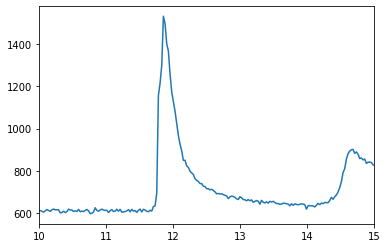

In [30]:

#
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{target.ID}.csv")
phi = lc.phi.values
flux = lc.flux.values
flux_err = lc.flux_err.values
t= lc.t.values
median = lc.median_[0]
median
plt.plot(phi,flux)
plt.xlim(10,15)

In [31]:

phi_a = (11.8,(target.t0 - t[0])/target.Prot_d * 2 * np.pi)
theta_a = 49*np.pi/180#target.theta_a_init
a = (1.5, target.ampl)
fwhm = (0.5, target.dur /target.Prot_d * 2 * np.pi/5)
i_mu = target.incl
i_sigma = target.incl_err
qlum = target.tlum * u.erg/u.s
R = target.rad * R_sun
phi0 = 240 * np.pi / 180
Fth = calculate_specific_flare_flux("TESS", flaret=1e4)
phi_a_max = (phi[-1], phi[-1])
for _a in a:
    radius = calculate_angular_radius(Fth, _a, qlum, R)
    print(radius)
theta_a, i_mu, phi_a


20.9253963026697
11.485683712824796


(0.8552113334772214, 0.3718561470554695, (11.8, 14.724101266474062))

(600, 1000)

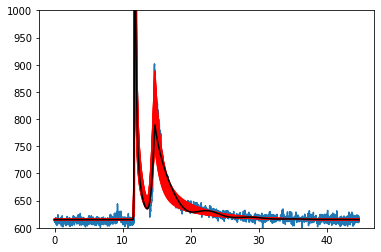

In [32]:
plt.plot(phi,flux)
for i in range(0,360,20):
    plt.plot(phi, full_model_2flares(phi_a, theta_a, a, fwhm, i_mu, phi0=i * np.pi / 180,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=1,)
plt.plot(phi, full_model_2flares(phi_a, theta_a, a, fwhm, i_mu, phi0=240 * np.pi / 180,
           phi=phi, num_pts=50, qlum=qlum,
           Fth=Fth, R=R, median=median), c="k", alpha=1,)
plt.ylim(600,1000)

### Save inits

In [14]:
with open(f"{CWD}/data/summary/inits.csv", "a") as f:
    firstout = "date,ID,phi_a,theta_a,a,fwhm,Fth,phi0,i_mu,i_sigma,radius_deg,R_Rsun,qlum_erg_s,median\n"
    out = (f"{tstamp},{target.ID},{phi_a},{theta_a},{a},{fwhm},{Fth.value},"\
           f"{phi0},{i_mu},{i_sigma},{radius},{(R/R_sun).value},{qlum.value},{median}\n")
   # f.write(firstout)
    f.write(out)

## Run MCMC

In [33]:
inits = np.array([*phi_a, theta_a, *a, *fwhm, i_mu, phi0]) 
pos = inits * (1. + 1e-3 * np.random.randn(32, 9))
nwalkers, ndim = pos.shape

In [15]:
# Set up the backend
# Don't forget to clear it in case the file already exists
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                backend=backend)

In [ ]:

sampler.run_mcmc(pos, 50000, progress=True, store=True);

 25%|██▍       | 12431/50000 [24:53:49<73:04:24,  7.00s/it]

LOG L ERROR


 33%|███▎      | 16341/50000 [32:32:07<65:51:21,  7.04s/it]

LOG L ERROR


 33%|███▎      | 16486/50000 [32:49:11<65:32:13,  7.04s/it]

LOG L ERROR


 35%|███▌      | 17621/50000 [35:02:38<63:05:09,  7.01s/it]

LOG L ERROR


 35%|███▌      | 17710/50000 [35:13:02<63:24:47,  7.07s/it]

LOG L ERROR


 36%|███▌      | 17776/50000 [35:20:45<62:52:59,  7.03s/it]

LOG L ERROR


 36%|███▌      | 17844/50000 [35:28:43<62:29:46,  7.00s/it]

LOG L ERROR


 36%|███▌      | 17932/50000 [35:39:03<63:02:44,  7.08s/it]

LOG L ERROR


 36%|███▌      | 18002/50000 [35:47:14<62:03:10,  6.98s/it]

LOG L ERROR


 37%|███▋      | 18497/50000 [36:45:28<62:24:02,  7.13s/it]

LOG L ERROR


 38%|███▊      | 18837/50000 [37:25:32<61:12:28,  7.07s/it]

LOG L ERROR


 45%|████▍     | 22296/50000 [44:09:34<54:30:25,  7.08s/it]

LOG L ERROR


 45%|████▌     | 22566/50000 [44:41:33<54:22:47,  7.14s/it]

LOG L ERROR


 81%|████████▏ | 40638/50000 [79:38:50<18:02:31,  6.94s/it]

LOG L ERROR


 81%|████████▏ | 40656/50000 [79:40:56<18:09:27,  7.00s/it]

LOG L ERROR


 81%|████████▏ | 40706/50000 [79:46:45<17:50:41,  6.91s/it]

LOG L ERROR


 82%|████████▏ | 40910/50000 [80:10:28<17:34:35,  6.96s/it]

LOG L ERROR


 82%|████████▏ | 40936/50000 [80:13:29<17:34:05,  6.98s/it]

LOG L ERROR


 93%|█████████▎| 46623/50000 [91:17:53<6:35:39,  7.03s/it] 

LOG L ERROR


 93%|█████████▎| 46697/50000 [91:26:33<6:25:23,  7.00s/it]

LOG L ERROR


 97%|█████████▋| 48646/50000 [95:21:37<2:42:43,  7.21s/it]

In [34]:
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"

new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))

Initial size: 48653


In [35]:
tstamp, target.ID

('23_12_2019_13_28', 237880881)

In [ ]:
new_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_2flares, 
                                    args=(phi, flux, flux_err, qlum, Fth, R, median, {"i_mu":i_mu,
                                      "i_sigma":i_sigma, "theta_a_min":0, "phi_a_max":phi_a_max}),
                                    backend=new_backend)
new_sampler.run_mcmc(None, 50000, progress=True, store=True)
print("Final size: {0}".format(new_backend.iteration))

  4%|▍         | 1914/50000 [3:52:09<96:04:22,  7.19s/it] 

LOG L ERROR


  4%|▍         | 1986/50000 [4:00:45<94:50:08,  7.11s/it]

LOG L ERROR


  4%|▍         | 2146/50000 [4:19:47<93:53:11,  7.06s/it]

LOG L ERROR


  4%|▍         | 2160/50000 [4:21:26<93:03:14,  7.00s/it]

LOG L ERROR


  5%|▍         | 2315/50000 [4:39:54<93:52:55,  7.09s/it]

LOG L ERROR


  5%|▍         | 2379/50000 [4:47:31<95:13:03,  7.20s/it]

LOG L ERROR


  5%|▍         | 2446/50000 [4:55:32<95:09:53,  7.20s/it]

LOG L ERROR


  5%|▌         | 2518/50000 [5:04:12<95:07:39,  7.21s/it]

LOG L ERROR


  5%|▌         | 2651/50000 [5:20:09<94:59:20,  7.22s/it]

LOG L ERROR


  6%|▌         | 2755/50000 [5:32:40<94:41:48,  7.22s/it]

LOG L ERROR


  7%|▋         | 3396/50000 [6:50:27<93:57:09,  7.26s/it] 

LOG L ERROR


 10%|▉         | 4844/50000 [9:47:50<93:02:27,  7.42s/it]

LOG L ERROR


 10%|▉         | 4995/50000 [10:06:34<93:41:20,  7.49s/it]

LOG L ERROR


 11%|█         | 5519/50000 [11:10:49<89:58:32,  7.28s/it]

LOG L ERROR


 14%|█▎        | 6788/50000 [13:49:04<90:30:23,  7.54s/it]

LOG L ERROR


 14%|█▎        | 6805/50000 [13:51:12<90:28:50,  7.54s/it]

LOG L ERROR


 15%|█▍        | 7269/50000 [14:49:41<89:20:56,  7.53s/it]

LOG L ERROR


 22%|██▏       | 10890/50000 [22:18:59<79:52:52,  7.35s/it]

LOG L ERROR


 23%|██▎       | 11350/50000 [23:15:05<78:36:00,  7.32s/it]

LOG L ERROR


 23%|██▎       | 11504/50000 [23:33:50<77:29:58,  7.25s/it]

LOG L ERROR


 24%|██▎       | 11788/50000 [24:08:30<77:50:40,  7.33s/it]

LOG L ERROR


 24%|██▍       | 11996/50000 [24:33:53<76:57:53,  7.29s/it]

LOG L ERROR


 24%|██▍       | 12137/50000 [24:51:05<78:01:25,  7.42s/it]

LOG L ERROR


 31%|███       | 15549/50000 [31:48:43<68:58:06,  7.21s/it]

LOG L ERROR


 32%|███▏      | 15820/50000 [32:21:32<68:55:59,  7.26s/it]

LOG L ERROR


 39%|███▉      | 19749/50000 [40:11:06<59:29:12,  7.08s/it] 

LOG L ERROR


 40%|████      | 20104/50000 [40:52:48<58:33:34,  7.05s/it]

LOG L ERROR


 44%|████▍     | 22115/50000 [44:50:35<55:23:45,  7.15s/it]

In [ ]:
# DEPRECATED SNIPPETS
# def t0_ED(x):
#     return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
# def dur_ED(x):
#     return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
# def ampl_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
# def median_ED(x):
#     return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
# E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
# E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
# E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
# E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
# np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

# check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
# assert E_median == pytest.approx(E_median,rel=1e-4)
# e_median, median

# EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
# e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
# EDval,e_ED